# CTA simulation tools
In this tutorial we will simulate the expected counts of a Fermi/LAT source in the CTA energy range. We will go through the following topics: 
 - handling of Fermi/LAT catalogues
 - handling of EBL tables
 - handling of CTA responses
 - simulation of an observation for a given set of parameters
 - Illustration of sherpa power (via ciao) to fit an observation with a user model

## Fermi/LAT catalogue
We will start by selecting the source PKS 2155-304 in the 3FHL Fermi/LAT catalogue for further use.

In [9]:
from gammapy.catalog import SourceCatalog3FHL

# load catalogs
fermi_3fhl = SourceCatalog3FHL()
name = 'PKS 2155-304'
src = fermi_3fhl[name]

We can then access the caracteristics of the source via the `data` attribut and select its spectral model for further use. 

In [10]:
redshift = src.data['Redshift']
spectral_model = src.spectral_model

Here is an example on how to plot the source spectra

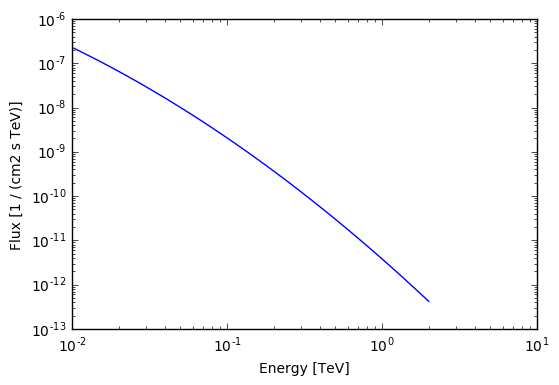

In [11]:
# plot the Fermi/LAT model
import astropy.units as u
import matplotlib.pyplot as plt
plt.figure('PKS 2155-305 spectrum')
spectral_model.plot(energy_range=[10 * u.GeV, 2 *u.TeV])
plt.show()

## Select a model for EBL absorption
We will need to modelise EBL (extragalactic background light) attenuation to have get a 'realistic' simulation. Different models are available in GammaPy. Here is an example on how to deal with the absorption coefficients. 

In [19]:
from gammapy.spectrum.models import TableModel

# Load models for PKS 2155-304 redshift 
franceschini = TableModel.read_xspec_model('$GAMMAPY_EXTRA/datasets/ebl/ebl_franceschini.fits.gz', param=redshift)
dominguez = TableModel.read_xspec_model('$GAMMAPY_EXTRA/datasets/ebl/ebl_dominguez11.fits.gz', param=redshift)
finke = TableModel.read_xspec_model('$GAMMAPY_EXTRA/datasets/ebl/frd_abs.fits.gz', param=redshift)

From here you can have access to the absorption coefficient for a given energy.

In [20]:
energy = 1 * u.TeV
abs = dominguez.evaluate(energy=energy, amplitude=1.)
print('abs({} {}) = {}'.format(energy.value, energy.unit, abs))

abs(1.0 TeV) = 0.273995804626


Below is an example to plot EBL absorption for different models 

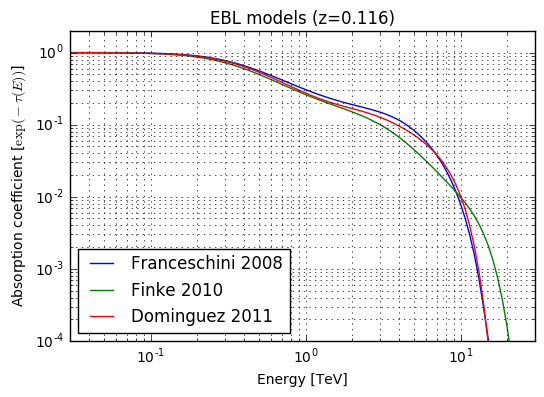

In [21]:
# define energy range for the plot
energy_range = [0.03, 30] * u.TeV

# start customised plot
ax = plt.gca()
label = {'label': 'Franceschini 2008'}  # for legend
franceschini.plot(energy_range=energy_range, energy_unit='TeV', ax=ax, **label)
label = {'label': 'Finke 2010'}  # for legend
finke.plot(energy_range=energy_range, energy_unit='TeV', ax=ax, **label)
label = {'label': 'Dominguez 2011'}  # for legend
dominguez.plot(energy_range=energy_range, energy_unit='TeV', ax=ax, **label)

# tune plot
ax.set_ylabel(r'Absorption coefficient [$\exp{(-\tau(E))}$]')
ax.set_xlim(energy_range.value)  # we get ride of units
ax.set_ylim([1.e-4, 2.])
ax.set_yscale('log')
ax.set_title('EBL models (z=' + str(redshift) + ')')
plt.grid(which='both')
plt.legend(loc='best') # legend

# show plot
plt.show()

Here we are going to select the Franceschini model (see simulation part)

In [22]:
ebl_model_name = 'franceschini'

## CTA instrument response functions
Here we are going to deal with CTA point-like instrument response functions (public version, production 2). Data format for point-like IRF is still missing. For now, a lot of efforts is made to define full-containment IRFs (https://gamma-astro-data-formats.readthedocs.io/en/latest/irfs/index.html). In the meantime a temporary format is used in gammapy. It will evolved.

To simulate one observation we need the following IRFs: 
 - effective area as a function of true energy (energy-dependent theta square cute)
 - background rate as a function of reconstructed energy (energy-dependent theta square cute)
 - migration matrix, e_reco/e_true as a function of true energy
 
To handle CTA's responses we will use the `CTAPerf` class

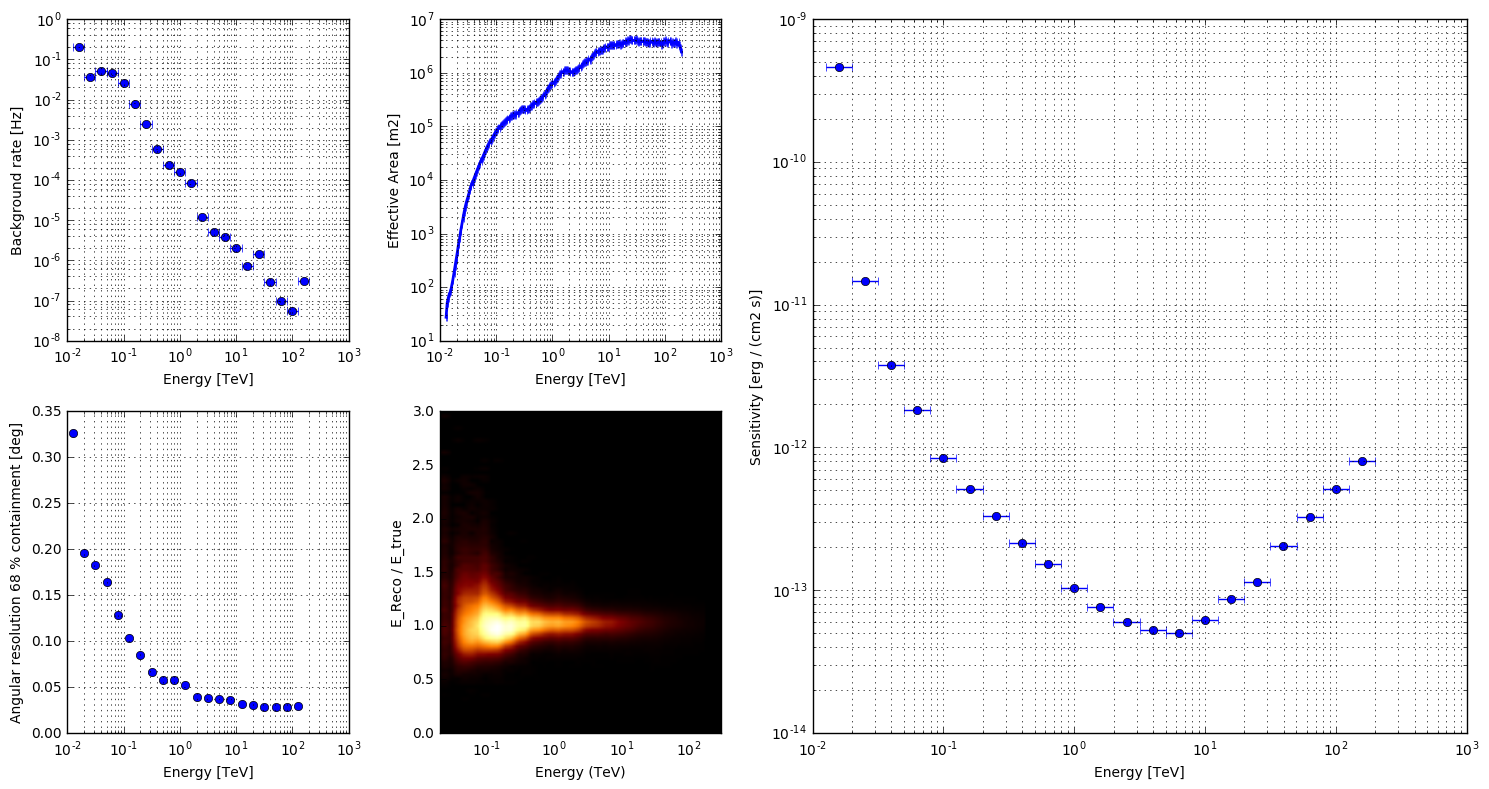

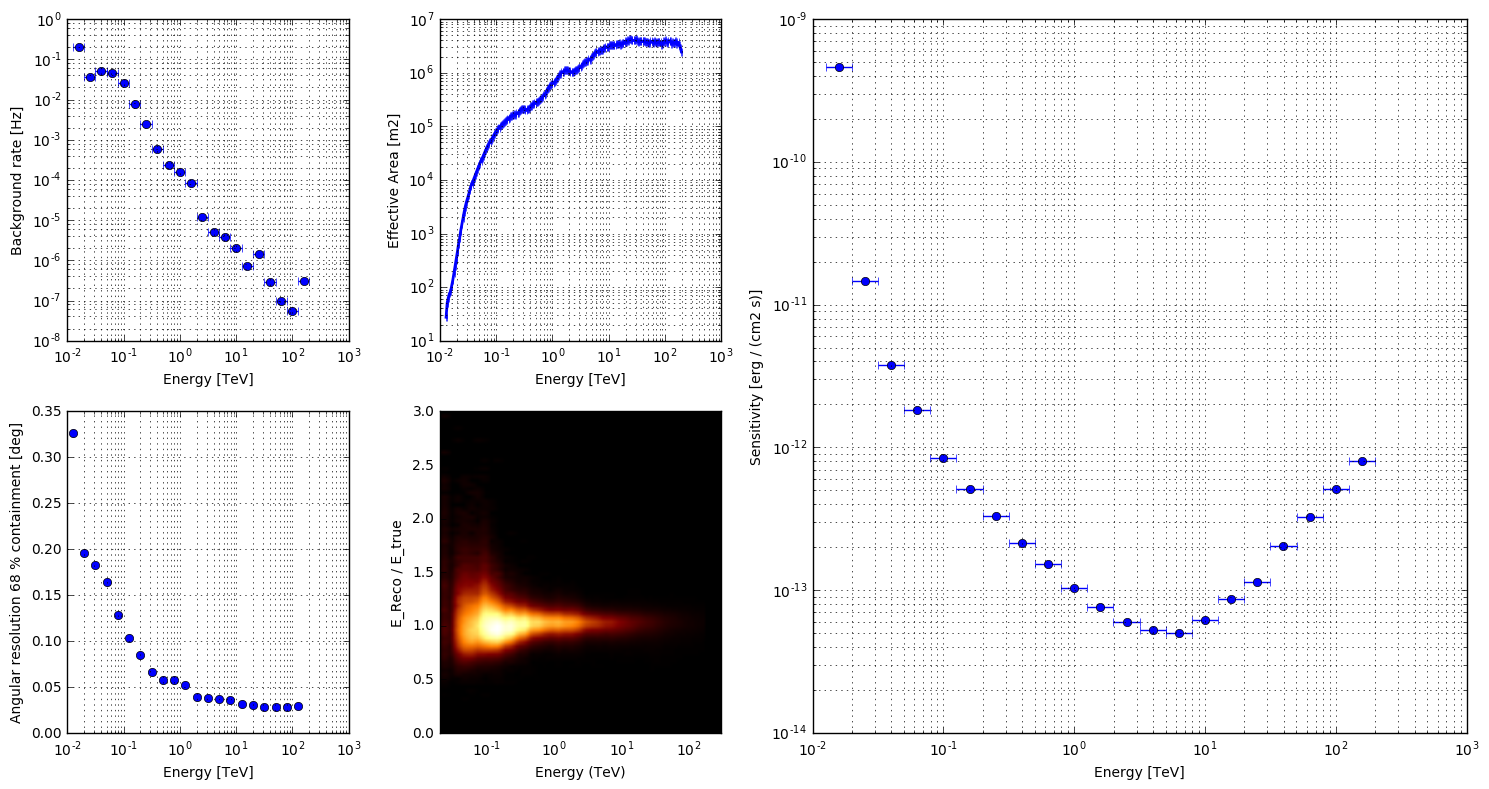

In [25]:
from gammapy.scripts import CTAPerf
# South array optimisation for faint source 
filename = '$GAMMAPY_EXTRA/datasets/cta/perf_prod2/point_like_non_smoothed/South_50h.fits.gz'
cta_perf = CTAPerf.read(filename)
cta_perf.peek()

Different optimisations are available for different type of source (bright, 0.5h; medium, 5h; faint, 50h). Here is an example to have a quick look to the different optimisation

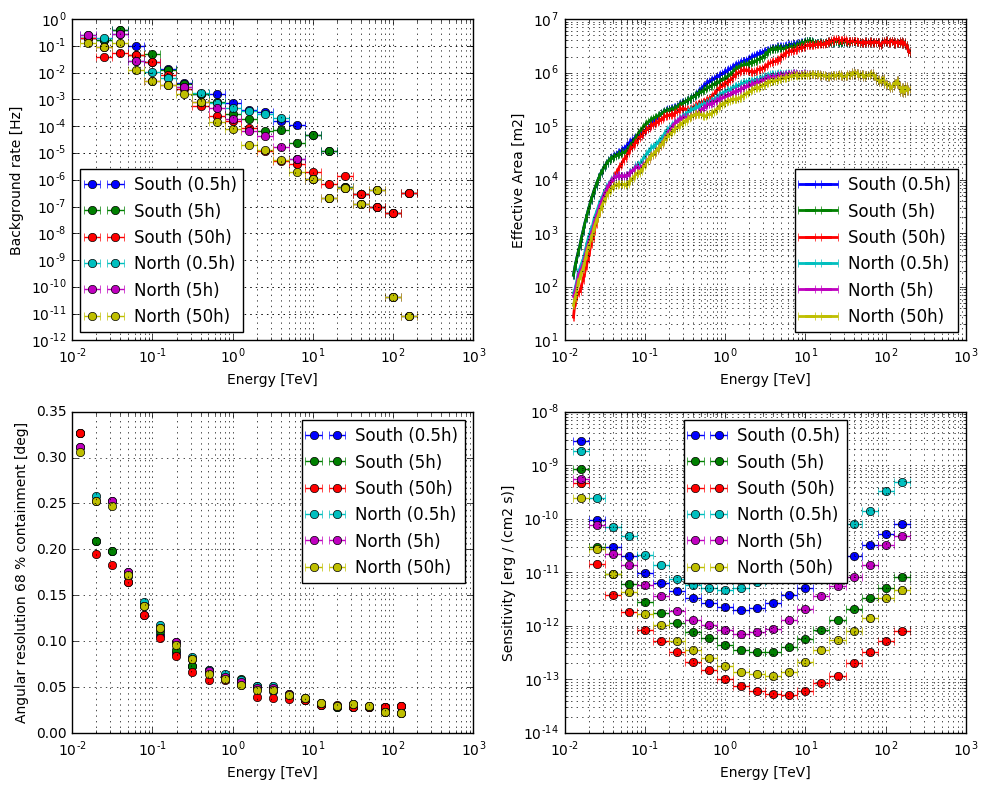

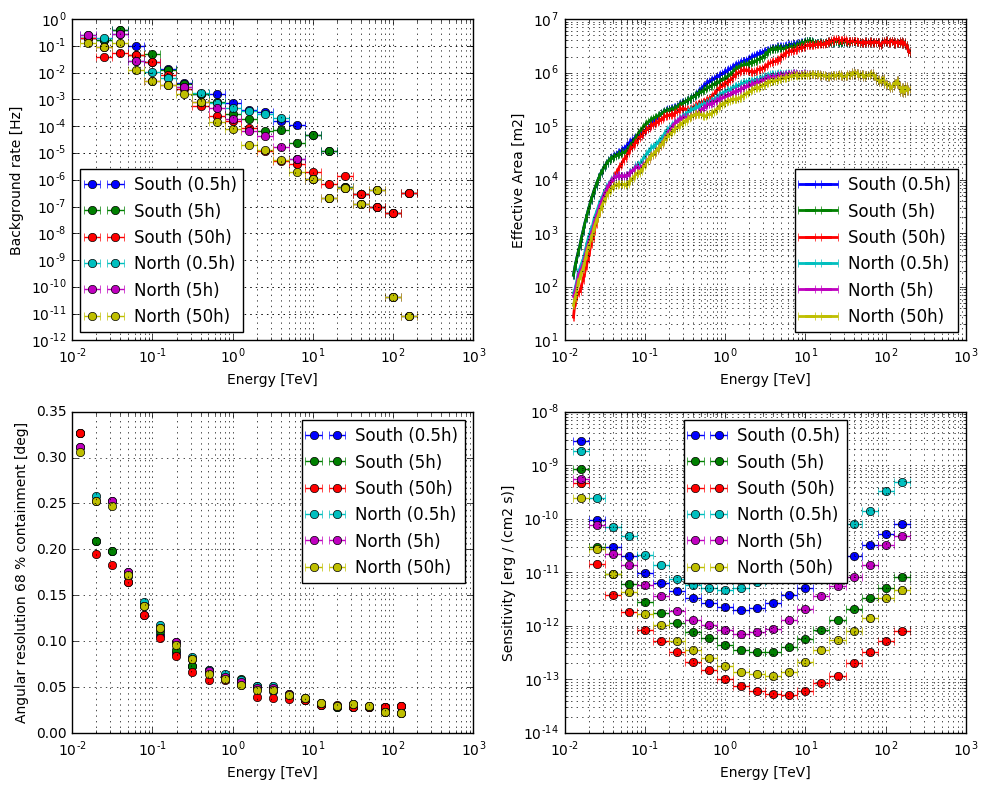

In [29]:
prod_dir = '$GAMMAPY_EXTRA/datasets/cta/perf_prod2/point_like_non_smoothed/'
opti = ['0.5h', '5h', '50h']
site = ['South', 'North']
cta_perf_list = list()  # will be filled with different performance
labels = list()  # will be filled with different performance labels for the legend
for isite in site: 
    for iopti in opti:
        filename = prod_dir + '/' + isite + '_' + iopti + '.fits.gz'
        cta_perf_list.append(CTAPerf.read(filename))
        labels.append(isite + ' (' + iopti + ')')
CTAPerf.superpose_perf(cta_perf_list, labels)

## CTA simulation of an observation
Now we are going to simulate the expected counts in the CTA energy range. To do so we will need to specify a target (caracteristics of the source) and the parameters of the observation (such as time, ON/OFF normalisation, etc.)

### Target definition

In [30]:
from gammapy.scripts.cta_utils import Target
target = Target(name=src.data['Source_Name'],  # from the 3FGL catalogue source class
                model=spectral_model,  # defined above
                redshift=redshift,  # defined above
                ebl_model_name=ebl_model_name  # defined above
               )

In [31]:
print(target)

*** Target parameters ***
Name=3FHL J2158.8-3013 
amplitude=7.70700170349e-11 1 / (cm2 GeV s)
reference=18.3173217773 GeV
alpha=1.88072741032 
beta=0.149697586894 
Redshift=0.115999996662


### Observation definition

In [45]:
from gammapy.scripts.cta_utils import ObservationParameters
alpha = 0.2 * u.Unit('')  # normalisation between ON and OFF regions
livetime = 5. * u.h
emin = 0.05 * u.TeV  # energy threshold range to do statistics (excess, significance, etc.)
emax = 5 * u.TeV  # energy threshold range to do statistics (excess, significance, etc.)
params = ObservationParameters(alpha=alpha, livetime=livetime,
                               emin=emin, emax=emax)

In [46]:
print(params)

*** Observation parameters summary ***
alpha=0.2 []
livetime=5.0 [h]
emin=0.05 [TeV]
emax=5.0 [TeV]



### Performance

In [47]:
# from gammapy.scripts import CTAPerf
# PKS 2155-304 is 10 % of Crab at 1 TeV ==> intermidiate source
filename = '$GAMMAPY_EXTRA/datasets/cta/perf_prod2/point_like_non_smoothed/South_5h.fits.gz'
perf = CTAPerf.read(filename)

### Simulation

Here we are going to simulate what we expect to see with CTA and measure the duration of the simulation

In [49]:
import time  # to estimate duration of a process
from gammapy.scripts.cta_utils import CTAObservationSimulation

t_start = time.clock()  # start timing
simu = CTAObservationSimulation.simulate_obs(perf=cta_perf,
                                             target=target,
                                             obs_param=params)
t_end = time.clock()

# print simulation results
print(simu)

# print time needed to run the simulation (0.015 s on my personal laptop)
print('\nsimu done in {} s'.format(t_end-t_start))

*** Observation summary report ***
Observation Id: 0
Livetime: 5.000 h
On events: 6104
Off events: 7431
Alpha: 0.200
Bkg events in On region: 1486.20
Excess: 4617.80
Excess / Background: 3.11
Gamma rate: 1.54 1 / min
Bkg rate: 0.50 1 / min
Sigma: 77.14
energy range: 0.05 TeV - 5.01 TeV

simu done in 0.02519 s


Now we can take a look at the excess, ON and OFF distributions

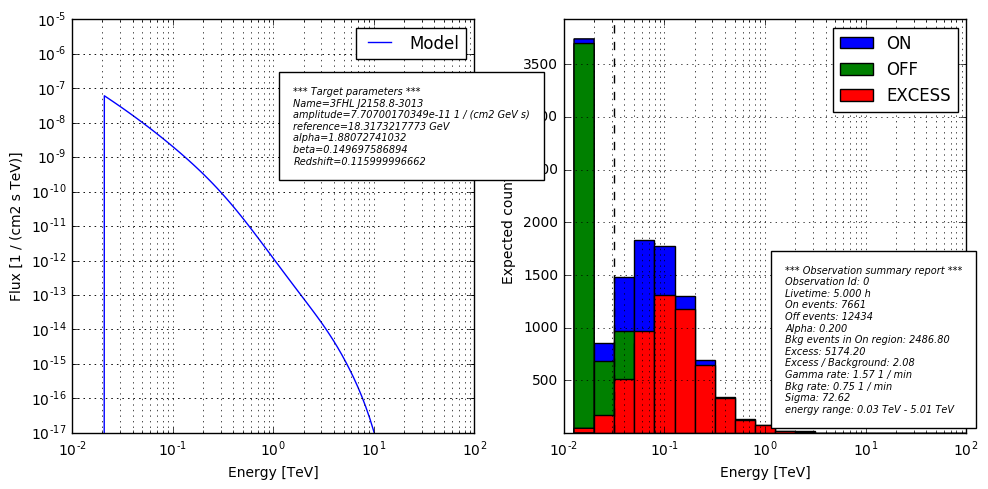

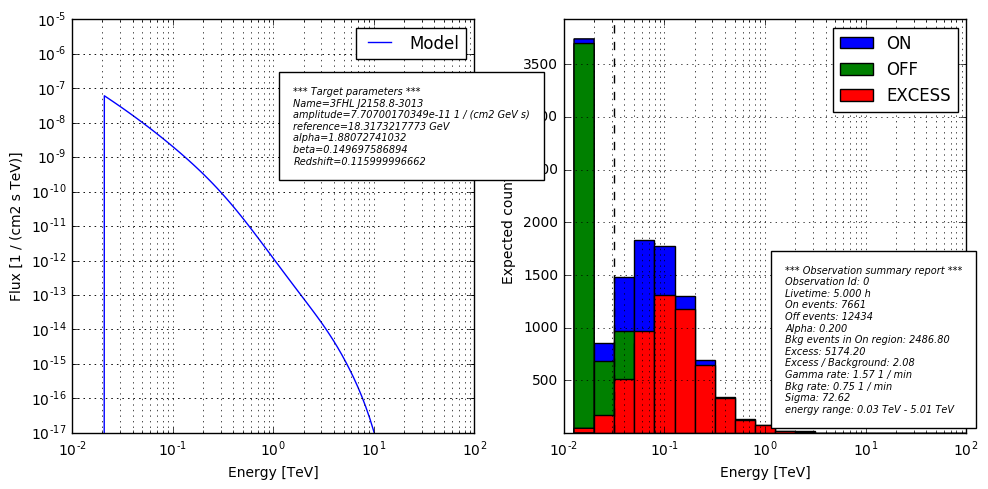

In [44]:
CTAObservationSimulation.plot_simu(simu, target)

## Fit a spectrum with sherpa (ciao) 